### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.vision.interpret import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [3]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/tmp'),
 PosixPath('../../data/siim_acr_pneu/preds'),
 PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [4]:
torch.cuda.set_device(7)

In [5]:
from mask_functions import *
from skimage.measure import label

### Workflow

- 1) Run segmentation on all valid and test images
- 2) Run classification on all test valid and images
- 3) Find optimal thresh
- 4) Submit

In [6]:
# this is needed or div=False
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

In [7]:
sz = 1024

In [8]:
torch.nn.Module.dump_patches = True

In [9]:
def load_learn(learn_path):
    learn = Learner(**torch.load(data_path/f'learn/{learn_path}'))
    learn.model.to('cuda');
    learn.data.train_dl.device = torch.device('cuda')
    learn.data.valid_dl.device = torch.device('cuda')
    learn.data.test_dl.device = torch.device('cuda')
    return learn

In [10]:
# clas_learn
# clas_learn = Learner(**torch.load(data_path/f'learn/clas-chexpert-ft-resnet34-{sz}'))
# clas_learn3 = Learner(**torch.load(data_path/f'learn/clas-chexpert-ft-densenet121-{sz}'))
# clas_learn4 = Learner(**torch.load(data_path/f'learn/clas-chexpert-ft-resnext50-{sz}'))
# clas_learn5 = Learner(**torch.load(data_path/f'learn/clas-densenet121-{sz}'))
# clas_learn6 = Learner(**torch.load(data_path/f'learn/clas-resnet34-{sz}'))

clas_learn = Learner(**torch.load(data_path/f'learn/clas-chexpert-ft-resnext34-{sz}'))

# clas_learn_collection = [clas_learn1, clas_learn2, clas_learn3]

In [11]:
# seg_learn
# seg_learn1 = Learner(**torch.load(data_path/f'learn/seg-resnet34-{sz}'))
# seg_learn2 = Learner(**torch.load(data_path/f'learn/seg-chexpert-ft-resnext34-{sz}'))
# seg_learn3 = Learner(**torch.load(data_path/f'learn/seg-chexpert-ft-resnet34-{sz}'))

n=5
seg_learn_collection = [load_learn(f'seg-chexpert-ft-resnext34-{sz}-{fold_idx}') for fold_idx in range(n)]

In [12]:
# clas_learn, seg_learn = clas_learn1, seg_learn2

### 1) Run seg on valid/test

In [ ]:
# Normal Preds
seg_valid_probs, seg_valid_targs = seg_learn.get_preds(DatasetType.Valid)
seg_test_probs, seg_test_targs = seg_learn.get_preds(DatasetType.Test)

In [ ]:
plt.imshow(np.concatenate((seg_valid_probs[0][1], seg_valid_targs[0][0]), axis=1))

In [13]:
len(seg_learn_collection)

5

In [13]:
# Getting predictions for 5 fold models
seg_valid_probs_list, seg_valid_targs_list = [], []
seg_test_probs_list, seg_test_targs_list = [], []

for i, seg_learn in enumerate(seg_learn_collection):
    seg_learn.to_fp16()
    seg_valid_probs, seg_valid_targs = seg_learn.get_preds(DatasetType.Valid)
    seg_test_probs, seg_test_targs = seg_learn.get_preds(DatasetType.Test)

    seg_valid_probs_list.append(seg_valid_probs)
    seg_valid_targs_list.append(seg_valid_targs)
    seg_test_probs_list.append(seg_test_probs)
    seg_test_targs_list.append(seg_test_targs_list)

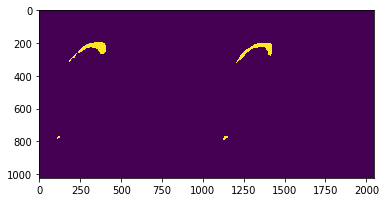

In [14]:
plt.imshow(np.concatenate((seg_valid_probs_list[0][0][1], seg_valid_targs_list[0][0][0]), axis=1))

In [15]:
from fastai.basic_train import _loss_func2activ
def _seg_tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, scale:float=1.35) -> Iterator[List[Tensor]]:
    "Computes the outputs for non-flip and flip_lr augmented inputs"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms

    try:
        pbar = master_bar(range(2))
        for i in pbar:
            tfm = [] # to remove random crop resize aug
            if i: tfm.append(flip_lr(p=1.))
            ds.tfms = tfm
            yield get_preds(learn.model, dl, pbar=pbar, activ=_loss_func2activ(learn.loss_func))[0]
    finally: ds.tfms = old

In [16]:
# flip_lr TTA preds
def seg_tta(seg_learn):
    non_flip_preds, flip_preds = list(_seg_tta_only(seg_learn, ds_type=DatasetType.Valid, scale=1))
    preds1, preds2 = non_flip_preds, torch.stack([torch.flip(o, dims=[-1]) for o in flip_preds], dim=0)
    seg_valid_probs = (preds1 + preds2)/2

    non_flip_preds, flip_preds = list(_seg_tta_only(seg_learn, ds_type=DatasetType.Test, scale=1))
    preds1, preds2 = non_flip_preds, torch.stack([torch.flip(o, dims=[-1]) for o in flip_preds], dim=0)
    seg_test_probs = (preds1 + preds2)/2
    return seg_valid_probs, seg_test_probs

In [17]:
# # multi model TTA + average ensemble
# seg_valid_probs_list, seg_test_probs_list = [], []

# for seg_learn in seg_learn_collection:
#     seg_learn.to_fp16()
#     seg_valid_probs, seg_test_probs = seg_tta(seg_learn)
#     seg_valid_probs_list.append(seg_valid_probs)
#     seg_test_probs_list.append(seg_test_probs)

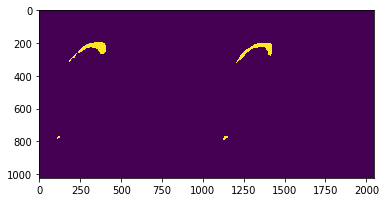

In [18]:
plt.imshow(np.concatenate((seg_valid_probs_list[0][0][1], seg_valid_targs_list[0][0][0]), axis=1))

In [19]:
len(seg_valid_probs_list)

5

### 1a) Semantic Dice 

In [20]:
def semantic_dice(input, target, t):
    '''
    semantic dice score with threshold 
    input: 1 mask probability per image
    target: 1 mask target per image
    '''
    input_hard = input[:,1,:,:] > t
    n = input_hard.shape[0]
    inputs = input_hard.float().view(n,-1)
    targs = target.float().view(n,-1)
    intersect = (inputs * targs).sum()
    union = (inputs+targs).sum()
    dice = ((2. * intersect) / union)
    return dice

def _dice_score(input, target):
    '''
    semantic dice score with (0,1) masks
    input: 1 mask pred per image
    target: 1 mask target per image
    '''
    n = input.shape[0]
    inputs = input.float().view(n,-1)
    targs = target.float().view(n,-1)
    intersect = (inputs * targs).sum()
    union = (inputs+targs).sum()
    dice = ((2. * intersect) / union)
    return dice

### 1b) Instance Dice [deprecated] 

In [21]:
# # rles for each validation image
# train_rle_df = pd.read_csv(data_path/'train-rle.csv')
# valid_image_ids = [Path(o).stem for o in seg_learn.data.valid_ds.items]
# valid_rle_dict = {o:train_rle_df[train_rle_df.ImageId == o][' EncodedPixels'].values for o in valid_image_ids}

# def rles2masks(rles):
#     'convert rles into list of (1024,1024) binary (0,1) masks'
#     masks = []
#     for rle in rles:
#         maskimg = PIL.Image.fromarray(rle2mask(rle, 1024, 1024).T.astype(np.uint8))
#         assert np.all(np.unique(np.asarray(maskimg)) == np.array([0,255]))
#         masks.append((np.asarray(maskimg)/255).astype(np.uint8))
#     return masks

# # create masks for all validation images
# valid_instance_targs = [np.array(rles2masks(valid_rle_dict[k])) for k in valid_image_ids]
# len(valid_instance_targs)

# # test
# masks = valid_instance_targs[0]
# for m in masks: assert np.all(np.unique(m) == np.array([0,1]))
# plt.imshow(np.concatenate(masks));

# seg_test_probs.shape

def prob2preds(prob, t, removal_thres=100):
    '''
    create instance preds from single mask probs 
    removal_thres: remove an instance pred if # of total pixels < removal_thres
    '''
    input_hard = prob[1,:,:] > t
    label_image = label(input_hard)
    unique_labels = np.unique(label_image)[1:]
    if len(unique_labels) > 0:
        instance_preds = [(label_image == l).astype(np.uint8) for l in unique_labels]
        instance_preds_resized = [np.asarray(PIL.Image.fromarray(arr).resize((1024,1024), 
                                    resample=PIL.Image.NEAREST)) for arr in instance_preds]
        # remove tiny instance preds
        if removal_thres is not None:
            instance_preds_resized = [arr for arr in instance_preds_resized if np.sum(arr) > removal_thres]
            if len(instance_preds_resized) == 0: instance_preds_resized = ['-1']
    else: instance_preds_resized = ['-1']

    return np.array(instance_preds_resized)

# t = 0.3
# valid_instance_preds = [prob2preds(prob, t, removal_thres=100) for prob in seg_valid_probs]

# # test
# i = np.random.choice(range(len(valid_instance_preds)))
# masks = valid_instance_preds[i]
# targ = valid_instance_targs[i]
# if masks != '-1':
#     for m in masks: assert np.all(np.unique(m) == np.array([0,1]))
#     fig, ax = plt.subplots(1,2)
#     ax[0].imshow(np.concatenate(masks)); ax[1].imshow(targ[0]);

# from scipy.optimize import linear_sum_assignment
# from tqdm import tqdm_notebook

# def instance_dice(instance_preds, instance_targs):
#     '''
#     instance dice score with threshold 
#     instance_preds: list of N_i mask (0,1) per image
#     instance_targs: list of M_i mask (0,1) target per image
#     '''
    
# #     # for plotting
# #     fig,axes=plt.subplots(1,2)
# #     axes[0].imshow(np.concatenate(valid_instance_targs[i]))
# #     axes[1].imshow(np.concatenate(valid_instance_preds[i]))
    
#     scores = []
#     for i in (range(len(instance_preds))):
#         if np.all(valid_instance_preds[i] == np.array(['-1'])): scores.append(0)
#         else:
#             m,_,_ = valid_instance_targs[i].shape
#             n,_,_ = valid_instance_preds[i].shape

#             targs = valid_instance_targs[i].reshape(m,-1)
#             preds = valid_instance_preds[i].reshape(n,-1)

#             # intersect: matrix of targ x preds (M, N)
#             intersect = ((targs[:,None,:]*preds[None,:,:]) > 0).sum(2)    
#             targs_area, preds_area = targs.sum(1), preds.sum(1)
#             union = targs_area[:, None] + preds_area[None,:]

#             dice = (2*intersect / union); dice
#             dice_scores = dice[linear_sum_assignment(1-dice)]
#             mean_dice_score = sum(dice_scores) / max(n, m) # unmatched gt or preds are counted as 0
#             scores.append(mean_dice_score)
#     return scores

### 1c) Best removal threshold and dice

In [22]:
from tqdm import tqdm_notebook

In [23]:
# dice scores at different probability thresholds
best_seg_thresholds = []

for fold_idx in range(5):
    # search for best_seg_thres
    best_dice, best_seg_thres = 0, None
    seg_valid_probs, seg_valid_targs = seg_valid_probs_list[fold_idx], seg_valid_targs_list[fold_idx]
    for t in np.linspace(0,1,21):
        d = semantic_dice(seg_valid_probs, seg_valid_targs, t=t)
        if d > best_dice: best_dice, best_seg_thres = d, t

    # search for best_removal_thres
    best_dice, best_removal_thres = 0, None
    for removal_t in tqdm_notebook(np.arange(0, 4000, 400)):
        # remove small island predictions by removal_thres
        valid_instance_preds = [prob2preds(prob, best_seg_thres, removal_thres=removal_t) 
                                for prob in seg_valid_probs]
        # combine individual label masks for each image
        valid_preds = tensor(np.array([sum(preds) if preds != '-1'
                                           else np.zeros((1024,1024)) for preds in valid_instance_preds]))
        # create (1024, 1024) valid preds and targs
        valid_targs = torch.stack([tensor(np.asarray(PIL.Image.fromarray(to_np(t[0]).astype(np.uint8))
                                  .resize((1024,1024), resample=PIL.Image.NEAREST))) for t in seg_valid_targs])
        # calc valid dice
        dice_score = _dice_score(valid_preds, valid_targs) 
        if dice_score > best_dice: best_dice, best_removal_thres = dice_score, removal_t

    best_seg_thresholds.append((best_dice, best_seg_thres, best_removal_thres))

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [24]:
# # TOO SLOW
# best_dice, best_seg_thres, best_removal_thres = 0, None, None
# dice_scores = {}
# for removal_t in np.arange(0, 2000*(sz/224), 200*(sz/224)):
#     for t in tqdm_notebook(np.linspace(0,1,11)):
#         # remove small island predictions by removal_thres
#         valid_instance_preds = [prob2preds(prob, t, removal_thres=removal_t) for prob in seg_valid_probs]

#         # combine individual label masks for each image
#         valid_preds = tensor(np.array([sum(preds) if preds != '-1'
#                                            else np.zeros((1024,1024)) for preds in valid_instance_preds]))

#         # create (1024, 1024) valid preds and targs
#         valid_targs = torch.stack([tensor(np.asarray(PIL.Image.fromarray(to_np(t[0]).astype(np.uint8))
#                                   .resize((1024,1024), resample=PIL.Image.NEAREST))) for t in seg_valid_targs])

#         # calc valid dice
#         dice_score = _dice_score(valid_preds, valid_targs) 
        
#         if dice_score > best_dice: best_dice, best_seg_thres, best_removal_thres= dice_score, t, removal_t
        
#         dice_scores[t] = dice_score

In [25]:
best_seg_thresholds

[(tensor(0.5374), 0.05, 800),
 (tensor(0.5621), 0.05, 1200),
 (tensor(0.5594), 0.05, 800),
 (tensor(0.5637), 0.05, 2000),
 (tensor(0.5492), 0.05, 1600)]

In [26]:
best_dice = np.mean([o[0] for o in best_seg_thresholds]); best_dice

0.55435956

### 2) Run clas on valid/test

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
# Normal Preds
clas_valid_probs, clas_valid_targs = clas_learn.get_preds(DatasetType.Valid)
clas_test_probs, clas_test_targs = clas_learn.get_preds(DatasetType.Test)

In [30]:
# TTA
clas_valid_probs, clas_valid_targs = clas_learn.TTA(beta=0.4, scale=1, ds_type=DatasetType.Valid)
clas_test_probs, clas_test_targs = clas_learn.TTA(beta=0.4, scale=1, ds_type=DatasetType.Test)

In [31]:
# # multi model TTA + average ensemble
# clas_valid_probs_list, _ = list(zip(*[clas_learn.TTA(beta=0.4, scale=1, ds_type=DatasetType.Valid) for clas_learn
#                                       in clas_learn_collection]))
# clas_test_probs_list, _ = list(zip(*[clas_learn.TTA(beta=0.4, scale=1, ds_type=DatasetType.Test) for clas_learn
#                                      in clas_learn_collection]))

# clas_valid_probs_list = torch.stack(clas_valid_probs_list, dim=0)
# clas_valid_probs = clas_valid_probs_list.mean(dim=0)
# clas_test_probs_list = torch.stack(clas_test_probs_list, dim=0)
# clas_test_probs = clas_test_probs_list.mean(dim=0)

In [32]:
clas_valid_probs, clas_valid_targs

(tensor([[0.9906, 0.0094],
         [0.0028, 0.9972],
         [0.0720, 0.9280],
         ...,
         [0.6796, 0.3204],
         [0.0344, 0.9656],
         [0.0047, 0.9953]]), tensor([0, 1, 1,  ..., 1, 1, 1]))

### 3) Grid search for best cls thres -  Calculate approx LB score 

In [33]:
def find_best_thres(best_dice=best_dice):
    "grid search for only cls_thres"
    best_score, best_cls_thres = 0, None
    
    for cls_thres in np.linspace(0,1,21):
        clas_valid_hard = clas_valid_probs[:, 1] > cls_thres
        cm = confusion_matrix(clas_valid_targs, clas_valid_hard)

        P_0_0 = cm[0,0] / cm[0, :].sum()
        P_1_1 = cm[1,1] / cm[1, :].sum()

        # public LB ratios
        R_1, R_0 = 0.7886, 0.2114
        score_cls, score_seg = R_1*P_1_1, R_0*P_0_0*best_dice
        total = score_cls + score_seg
        print(cls_thres, total)
        # update
        if total > best_score:
            best_score, best_cls_thres  = total, cls_thres
            best_score_cls, best_score_seg = score_cls, score_seg

    return (best_score, best_cls_thres)


In [34]:
best_score, best_cls_thres = find_best_thres()
print(best_score, best_cls_thres)

0.0 0.7886
0.05 0.8149508665664971
0.1 0.8265093701713352
0.15000000000000002 0.8316548627993837
0.2 0.8320668620300733
0.25 0.8328179168423162
0.30000000000000004 0.8316755742956157
0.35000000000000003 0.8319441618119806
0.4 0.8337488551934518
0.45 0.8296230048940112
0.5 0.8234785814335868
0.55 0.8222110630848456
0.6000000000000001 0.818317328477202
0.65 0.8111192664475492
0.7000000000000001 0.7975264293533907
0.75 0.7850054667407446
0.8 0.7717699211404235
0.8500000000000001 0.7386537032711951
0.9 0.6916942967037271
0.9500000000000001 0.5516011280541864
1.0 0.11719160997867585
0.8337488551934518 0.4


### 4) Submit

- Convert segmentation probas to binary 
- Resize to 1024, 1024
- Separate instances
- Convert individual masks to rle

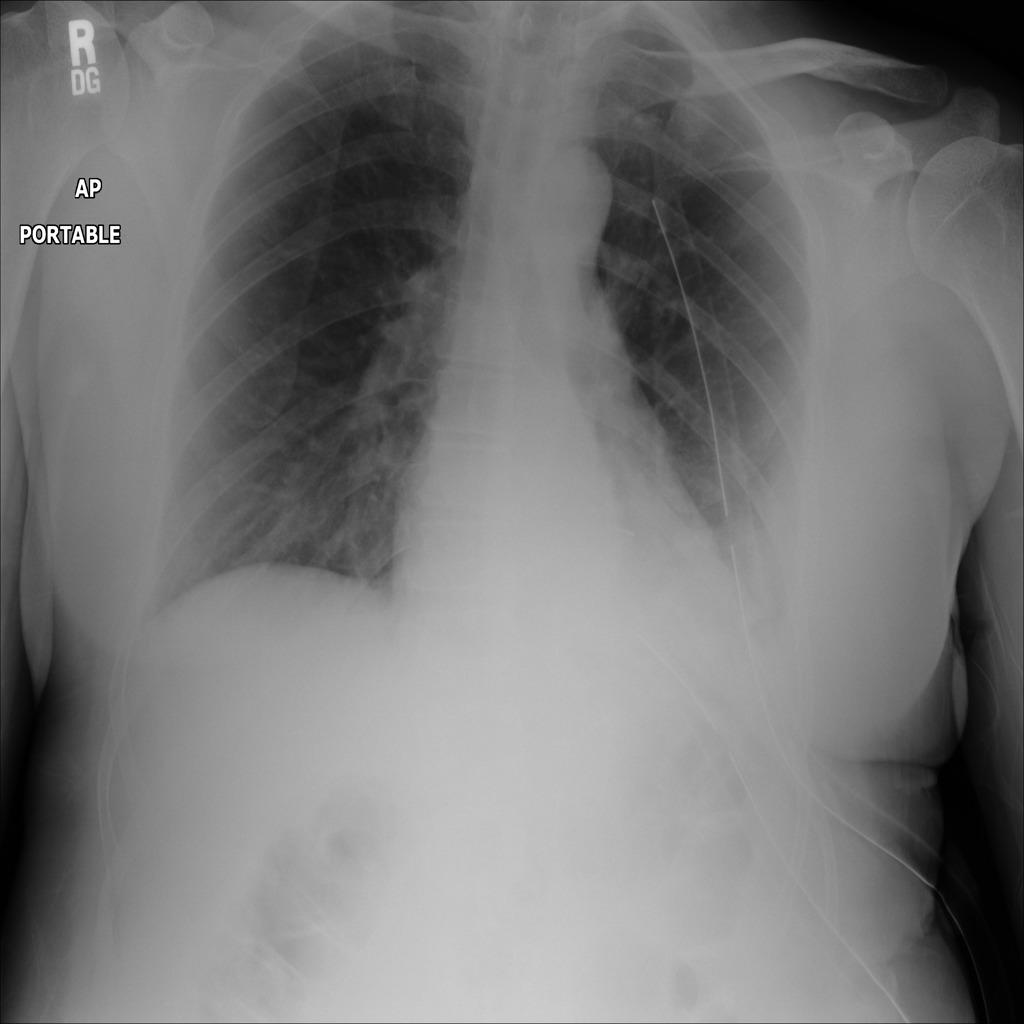

In [35]:
seg_learn_collection[0].data.test_ds[0][0]

In [36]:
seg_test_probs_list[0][0][0].shape

torch.Size([1024, 1024])

In [37]:
best_seg_thresholds

[(tensor(0.5374), 0.05, 800),
 (tensor(0.5621), 0.05, 1200),
 (tensor(0.5594), 0.05, 800),
 (tensor(0.5637), 0.05, 2000),
 (tensor(0.5492), 0.05, 1600)]

In [38]:
test_preds_list = []
for seg_test_probs, (_, best_seg_thres, removal_t) in zip(seg_test_probs_list, best_seg_thresholds):
    # remove small island predictions by removal_thres
    test_instance_preds = [prob2preds(prob, best_seg_thres, removal_thres=removal_t) 
                            for prob in seg_test_probs]

    # combine individual label masks for each image
    test_preds = np.array([sum(preds) if preds != '-1' else preds for preds in test_instance_preds])
    
    test_preds_list.append(test_preds)

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [39]:
# Majority vote ensemble
test_preds_tuples = list(zip(*test_preds_list))

In [40]:
test_preds_tuples[7]

(array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0,

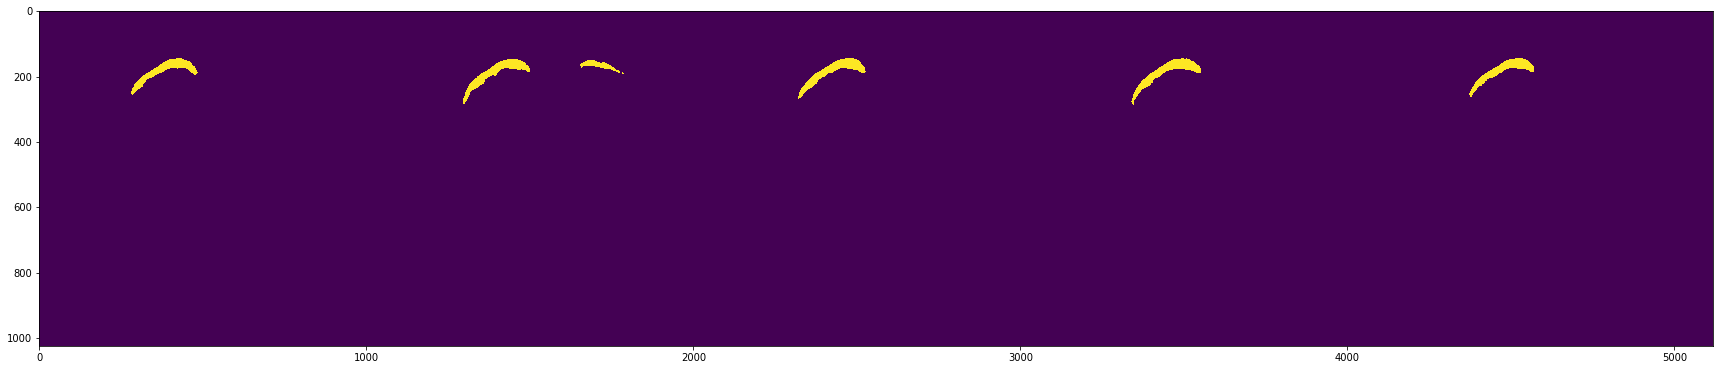

In [42]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
ax.imshow(np.concatenate(test_preds_tuples[2], axis=1))

In [43]:
def majority_vote(test_preds_list):
    "Get majority vote ensemble from kfold hard preds"
    maj_vote_preds = []
    for test_preds in test_preds_list:
        non_mask_count = 0
        for pred in test_preds:
            if pred == '-1': non_mask_count += 1
        if non_mask_count > 2: 
            maj_vote_preds.append(np.array(['-1']))
        else:
            summed_pred = sum([pred for pred in test_preds if pred != '-1' ])
            maj_vote_preds.append((summed_pred > 2).astype(np.uint8))
    return maj_vote_preds


In [44]:
seg_test_hard = majority_vote(test_preds_tuples)

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


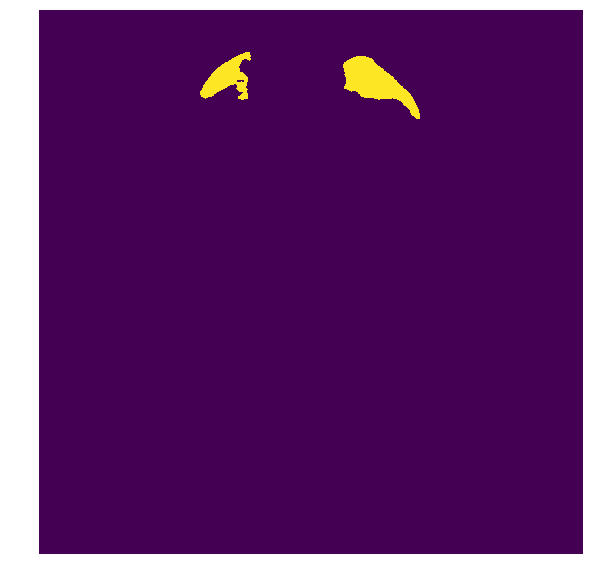

In [45]:
(ImageSegment(tensor(seg_test_hard[4][None,:]))
    .show(cmap='viridis', alpha=1, figsize=(10,10)))

In [46]:
np.mean([True if pred == '-1' else False for pred in seg_test_hard])

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


0.4851125635439361

In [47]:
def test_preds2rles(seg_test_hard, has_pneumo):
    rle_preds = []
    for pneumo, test_hard in zip(has_pneumo, seg_test_hard):
        if pneumo: 
            if test_hard == '-1':
                rle_preds.append('-1')
            else:
                rle = mask2rle(test_hard.T*255, *(1024,1024))
                rle_preds.append(rle)
        else: 
            rle_preds.append('-1')
    return rle_preds

In [48]:
# find images to submit mask predictions for
has_pneumo = to_np((clas_test_probs[:, 1] < best_cls_thres)).astype(bool)
rle_preds = test_preds2rles(seg_test_hard, has_pneumo)

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [49]:
np.mean(has_pneumo)

0.17719680464778503

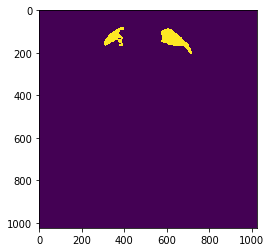

In [50]:
plt.imshow(rle2mask(rle_preds[4], 1024,1024).T)

In [51]:
# extract test image ids
test_image_ids = np.array([o.stem for o in seg_learn.data.test_ds.items])
final_sub = pd.DataFrame({"ImageId": test_image_ids, "EncodedPixels":rle_preds})
final_sub.to_csv("sub.csv", index=False)

In [52]:
final_sub.shape

(1377, 2)

In [53]:
from IPython.display import FileLink
FileLink("sub.csv")

/home/turgutluk/git/siim_acr_pneu/sub.csv